In [147]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multivariate GRU

In [148]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Dataset

In [149]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from config import interim_data_dir, raw_data_dir
from src.utils import read_shapefile
from config import processed_data_dir

dataset_version = 'v8.1'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)

# This is necessary for some reason
train_features_df.farm_id = train_features_df.farm_id.astype(str)
test_features_df.farm_id = test_features_df.farm_id.astype(str)

class_weight = 1-train_features_df.y.value_counts(normalize=True)

train_features_df.shape, test_features_df.shape

((19952, 54), (8592, 87))

## Preprocess Data

1. Impute Nans
2. Scale features

In [150]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
    for ts, ts_df in df.groupby('time'):
        df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df
        
    
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)

### 2. Scale Features

In [151]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()

feature_cols = [col for col in train_features_df.columns if col not in ['farm_id','y','time']]

train_scaled = train_features_df.copy()
test_scaled = test_features_df.copy()

train_scaled.loc[:, feature_cols] = scaler.fit_transform(train_features_df[feature_cols])
test_scaled.loc[:, feature_cols] = scaler.transform(test_features_df[feature_cols])

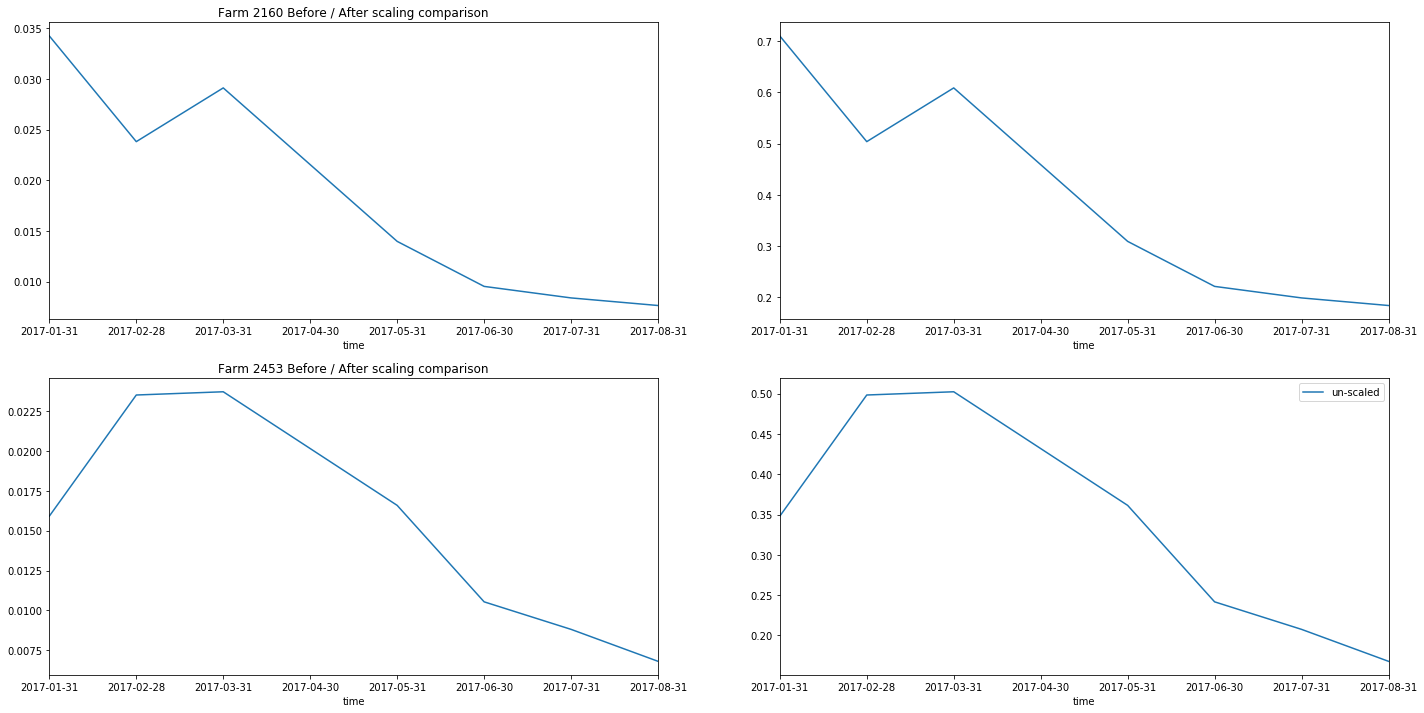

In [152]:
random_id_train = np.random.choice(train_features_df.farm_id.unique())
random_id_test = np.random.choice(test_features_df.farm_id.unique())

fig, axes = plt.subplots(2,2,figsize=(24,12))

train_scaled.set_index(['farm_id','time']).loc[random_id_train,:]['ndvi_mean'].plot(title=f'Farm {random_id_train} Before / After scaling comparison', ax=axes[0][0], label='scaled')
train_features_df.set_index(['farm_id','time']).loc[random_id_train,:]['ndvi_mean'].plot(ax=axes[0][1], label='un-scaled')

test_scaled.set_index(['farm_id','time']).loc[random_id_test,:]['ndvi_mean'].plot(title=f'Farm {random_id_test} Before / After scaling comparison', ax=axes[1][0], label='scaled')
test_features_df.set_index(['farm_id','time']).loc[random_id_test,:]['ndvi_mean'].plot(ax=axes[1][1], label='un-scaled')

plt.legend()

#### Inspect feature distributions

In [153]:
train_scaled[feature_cols].describe().T.sort_values(by='max', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
reip_mean,19952.0,0.199563,0.149886,0.0,0.073777,0.159744,0.294466,1.0
gari_mean,19952.0,0.285179,0.093217,0.0,0.206347,0.290386,0.365007,1.0
arvi_mean,19952.0,0.054441,0.047070,0.0,0.030286,0.052126,0.070842,1.0
arvi_std,19952.0,0.020086,0.064808,0.0,0.006543,0.009405,0.013032,1.0
datt1_std,19952.0,0.000340,0.010477,0.0,0.000004,0.000006,0.000011,1.0


In [154]:
train_features_df[feature_cols].describe().T.sort_values(by='max', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
msbi_median,19952.0,1424.461795,2041.928211,0.0,0.000000,0.000000,3647.960500,7285.797500
datt1_std,19952.0,2.396993,73.865470,0.0,0.026089,0.043193,0.074953,7050.050502
msbi_mean,19952.0,2064.303612,762.330394,0.0,1578.486578,2021.366563,2498.676090,5494.464365
msbi_std,19952.0,2161.901716,455.784150,0.0,1887.600507,2145.334951,2448.929112,4131.195809
mnsi_median,19952.0,407.207982,589.290546,0.0,0.000000,0.000000,1021.000875,2275.772000


## Create Train / Val Split with oversampling

1. Create wide-form dataset
2. Split out val set
3. Oversample train set
4. Turn back into long-form

### 1. Create Wide Dataset

In [155]:
from sklearn.model_selection import train_test_split

feature_cols = [c for c in train_features_df.columns.to_list() if c not in ['time','farm_id','y']]

def long_to_wide(df):
    
    df_long = pd.pivot(df, index='farm_id', columns='time')
    
    columns = ['-'.join(col_pair) for col_pair in df_long.columns if 'y' not in col_pair]
    
    if 'y' in df:
        
        classes = {}
        for farm_id, farm_group in df.groupby('farm_id'):
            classes[farm_id] = farm_group.y.unique()[0]
        
        labels = pd.Series(classes, name='y')
        
        df_long.drop('y', axis=1, inplace=True)
        
        df_long = df_long.join(labels, on='farm_id')
        
        columns.append('y')
        
    df_long.columns = columns
    
    return df_long

In [156]:
# Make wide-form training set
train_features_df_wide = long_to_wide(train_scaled)
train_features_df_wide.head()

,reip_mean-2017-01-31,reip_mean-2017-02-28,reip_mean-2017-03-31,reip_mean-2017-04-30,reip_mean-2017-05-31,reip_mean-2017-06-30,reip_mean-2017-07-31,reip_mean-2017-08-31,reip_median-2017-01-31,reip_median-2017-02-28,reip_median-2017-03-31,reip_median-2017-04-30,reip_median-2017-05-31,reip_median-2017-06-30,reip_median-2017-07-31,reip_median-2017-08-31,reip_std-2017-01-31,reip_std-2017-02-28,reip_std-2017-03-31,reip_std-2017-04-30,reip_std-2017-05-31,reip_std-2017-06-30,reip_std-2017-07-31,reip_std-2017-08-31,bri_mean-2017-01-31,bri_mean-2017-02-28,bri_mean-2017-03-31,bri_mean-2017-04-30,bri_mean-2017-05-31,bri_mean-2017-06-30,bri_mean-2017-07-31,bri_mean-2017-08-31,bri_median-2017-01-31,bri_median-2017-02-28,bri_median-2017-03-31,bri_median-2017-04-30,bri_median-2017-05-31,bri_median-2017-06-30,bri_median-2017-07-31,bri_median-2017-08-31,bri_std-2017-01-31,bri_std-2017-02-28,bri_std-2017-03-31,bri_std-2017-04-30,bri_std-2017-05-31,bri_std-2017-06-30,bri_std-2017-07-31,bri_std-2017-08-31,ipvi_mean-2017-01-31,ipvi_mean-2017-02-28,ipvi_mean-2017-03-31,ipvi_mean-2017-04-30,ipvi_mean-2017-05-31,ipvi_mean-2017-06-30,ipvi_mean-2017-07-31,ipvi_mean-2017-08-31,ipvi_median-2017-01-31,ipvi_median-2017-02-28,ipvi_median-2017-03-31,ipvi_median-2017-04-30,ipvi_median-2017-05-31,ipvi_median-2017-06-30,ipvi_median-2017-07-31,ipvi_median-2017-08-31,ipvi_std-2017-01-31,ipvi_std-2017-02-28,ipvi_std-2017-03-31,ipvi_std-2017-04-30,ipvi_std-2017-05-31,ipvi_std-2017-06-30,ipvi_std-2017-07-31,ipvi_std-2017-08-31,savi_mean-2017-01-31,savi_mean-2017-02-28,savi_mean-2017-03-31,savi_mean-2017-04-30,savi_mean-2017-05-31,savi_mean-2017-06-30,savi_mean-2017-07-31,savi_mean-2017-08-31,savi_median-2017-01-31,savi_median-2017-02-28,savi_median-2017-03-31,savi_median-2017-04-30,savi_median-2017-05-31,savi_median-2017-06-30,savi_median-2017-07-31,savi_median-2017-08-31,savi_std-2017-01-31,savi_std-2017-02-28,savi_std-2017-03-31,savi_std-2017-04-30,savi_std-2017-05-31,...,gari_mean-2017-05-31,gari_mean-2017-06-30,gari_mean-2017-07-31,gari_mean-2017-08-31,gari_median-2017-01-31,gari_median-2017-02-28,gari_median-2017-03-31,gari_median-2017-04-30,gari_median-2017-05-31,gari_median-2017-06-30,gari_median-2017-07-31,gari_median-2017-08-31,gari_std-2017-01-31,gari_std-2017-02-28,gari_std-2017-03-31,gari_std-2017-04-30,gari_std-2017-05-31,gari_std-2017-06-30,gari_std-2017-07-31,gari_std-2017-08-31,gbndvi_mean-2017-01-31,gbndvi_mean-2017-02-28,gbndvi_mean-2017-03-31,gbndvi_mean-2017-04-30,gbndvi_mean-2017-05-31,gbndvi_mean-2017-06-30,gbndvi_mean-2017-07-31,gbndvi_mean-2017-08-31,gbndvi_median-2017-01-31,gbndvi_median-2017-02-28,gbndvi_median-2017-03-31,gbndvi_median-2017-04-30,gbndvi_median-2017-05-31,gbndvi_median-2017-06-30,gbndvi_median-2017-07-31,gbndvi_median-2017-08-31,gbndvi_std-2017-01-31,gbndvi_std-2017-02-28,gbndvi_std-2017-03-31,gbndvi_std-2017-04-30,gbndvi_std-2017-05-31,gbndvi_std-2017-06-30,gbndvi_std-2017-07-31,gbndvi_std-2017-08-31,mnsi_mean-2017-01-31,mnsi_mean-2017-02-28,mnsi_mean-2017-03-31,mnsi_mean-2017-04-30,mnsi_mean-2017-05-31,mnsi_mean-2017-06-30,mnsi_mean-2017-07-31,mnsi_mean-2017-08-31,mnsi_median-2017-01-31,mnsi_median-2017-02-28,mnsi_median-2017-03-31,mnsi_median-2017-04-30,mnsi_median-2017-05-31,mnsi_median-2017-06-30,mnsi_median-2017-07-31,mnsi_median-2017-08-31,mnsi_std-2017-01-31,mnsi_std-2017-02-28,mnsi_std-2017-03-31,mnsi_std-2017-04-30,mnsi_std-2017-05-31,mnsi_std-2017-06-30,mnsi_std-2017-07-31,mnsi_std-2017-08-31,msbi_mean-2017-01-31,msbi_mean-2017-02-28,msbi_mean-2017-03-31,msbi_mean-2017-04-30,msbi_mean-2017-05-31,msbi_mean-2017-06-30,msbi_mean-2017-07-31,msbi_mean-2017-08-31,msbi_median-2017-01-31,msbi_median-2017-02-28,msbi_median-2017-03-31,msbi_median-2017-04-30,msbi_median-2017-05-31,msbi_median-2017-06-30,msbi_median-2017-07-31,msbi_median-2017-08-31,msbi_std-2017-01-31,msbi_std-2017-02-28,msbi_std-2017-03-31,msbi_std-2017-04-30,msbi_std-2017-05-31,msbi_std-2017-06-30,msbi_std-2017-07-31,msbi_std-2017-08-31,y
farm_id,,,,,,,,,,

### 2. Split out val set

In [193]:
# Split out val set
X_wide = train_features_df_wide.drop('y', axis=1)
y = train_features_df_wide.y

X_train_wide, X_val_wide, y_train, y_val = train_test_split(X_wide, y, stratify=y, test_size=0.2, random_state=2019)

# Save for later
wide_col_names = X_wide.columns
X_wide_train_index = X_train_wide.index

X_train_wide.shape, X_val_wide.shape

((1995, 408), (499, 408))

In [194]:
y_train.value_counts()

Vineyard                          753
Lucern                            429
Maize                             226
Vacant                            213
Pecan                             117
Cotton                            113
Grass                              76
Vineyard & Pecan ("Intercrop")     62
Dates                               6
Name: y, dtype: int64

### 3. Over Sample

1. Random up-sample `Dates` to 10 samples
2. Synthetically up-sample all clases below certain value (tuning)

In [195]:
from imblearn.over_sampling import RandomOverSampler

# Up sample dates
random = RandomOverSampler({'Dates': 10},random_state=2019)
X_train_temp, y_train_temp = random.fit_resample(X_train_wide, y_train)

pd.Series(y_train_temp).value_counts()

Vineyard                          753
Lucern                            429
Maize                             226
Vacant                            213
Pecan                             117
Cotton                            113
Grass                              76
Vineyard & Pecan ("Intercrop")     62
Dates                              10
dtype: int64

In [213]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek


# oversample the training set
sample = ADASYN(sampling_strategy={
                'Grass': 180,
                'Vineyard & Pecan ("Intercrop")':  120,
                'Dates': 60,
                'Pecan': 200,
              }, 
              random_state=2019,
              )

X_train_wide_resampled, y_train_resampled = sample.fit_resample(X_train_temp, y_train_temp)

In [214]:
pd.Series(y_train_resampled).value_counts()

Vineyard                          753
Lucern                            429
Maize                             226
Vacant                            213
Pecan                             201
Grass                             193
Vineyard & Pecan ("Intercrop")    121
Cotton                            113
Dates                              60
dtype: int64

**Turn oversampled data into DataFrame with new Farm IDs**

In [216]:
# Turn oversampled training set into long form
X_train_wide = pd.DataFrame(X_train_wide_resampled, columns=wide_col_names)

# Make new index
new_train_index = pd.Index(data=list(X_wide_train_index) + [f'os_{i}' for i in range(X_train_wide.shape[0] - len(X_wide_train_index))])

# Use this when using combined over-sampling
# new_train_index = pd.Index(range(len(X_train_wide)))

X_train_wide['farm_id'] = new_train_index
y_train = pd.Series(y_train_resampled, index=new_train_index, name='y')

X_train_wide.tail()

,reip_mean-2017-01-31,reip_mean-2017-02-28,reip_mean-2017-03-31,reip_mean-2017-04-30,reip_mean-2017-05-31,reip_mean-2017-06-30,reip_mean-2017-07-31,reip_mean-2017-08-31,reip_median-2017-01-31,reip_median-2017-02-28,reip_median-2017-03-31,reip_median-2017-04-30,reip_median-2017-05-31,reip_median-2017-06-30,reip_median-2017-07-31,reip_median-2017-08-31,reip_std-2017-01-31,reip_std-2017-02-28,reip_std-2017-03-31,reip_std-2017-04-30,reip_std-2017-05-31,reip_std-2017-06-30,reip_std-2017-07-31,reip_std-2017-08-31,bri_mean-2017-01-31,bri_mean-2017-02-28,bri_mean-2017-03-31,bri_mean-2017-04-30,bri_mean-2017-05-31,bri_mean-2017-06-30,bri_mean-2017-07-31,bri_mean-2017-08-31,bri_median-2017-01-31,bri_median-2017-02-28,bri_median-2017-03-31,bri_median-2017-04-30,bri_median-2017-05-31,bri_median-2017-06-30,bri_median-2017-07-31,bri_median-2017-08-31,bri_std-2017-01-31,bri_std-2017-02-28,bri_std-2017-03-31,bri_std-2017-04-30,bri_std-2017-05-31,bri_std-2017-06-30,bri_std-2017-07-31,bri_std-2017-08-31,ipvi_mean-2017-01-31,ipvi_mean-2017-02-28,ipvi_mean-2017-03-31,ipvi_mean-2017-04-30,ipvi_mean-2017-05-31,ipvi_mean-2017-06-30,ipvi_mean-2017-07-31,ipvi_mean-2017-08-31,ipvi_median-2017-01-31,ipvi_median-2017-02-28,ipvi_median-2017-03-31,ipvi_median-2017-04-30,ipvi_median-2017-05-31,ipvi_median-2017-06-30,ipvi_median-2017-07-31,ipvi_median-2017-08-31,ipvi_std-2017-01-31,ipvi_std-2017-02-28,ipvi_std-2017-03-31,ipvi_std-2017-04-30,ipvi_std-2017-05-31,ipvi_std-2017-06-30,ipvi_std-2017-07-31,ipvi_std-2017-08-31,savi_mean-2017-01-31,savi_mean-2017-02-28,savi_mean-2017-03-31,savi_mean-2017-04-30,savi_mean-2017-05-31,savi_mean-2017-06-30,savi_mean-2017-07-31,savi_mean-2017-08-31,savi_median-2017-01-31,savi_median-2017-02-28,savi_median-2017-03-31,savi_median-2017-04-30,savi_median-2017-05-31,savi_median-2017-06-30,savi_median-2017-07-31,savi_median-2017-08-31,savi_std-2017-01-31,savi_std-2017-02-28,savi_std-2017-03-31,savi_std-2017-04-30,savi_std-2017-05-31,...,gari_mean-2017-05-31,gari_mean-2017-06-30,gari_mean-2017-07-31,gari_mean-2017-08-31,gari_median-2017-01-31,gari_median-2017-02-28,gari_median-2017-03-31,gari_median-2017-04-30,gari_median-2017-05-31,gari_median-2017-06-30,gari_median-2017-07-31,gari_median-2017-08-31,gari_std-2017-01-31,gari_std-2017-02-28,gari_std-2017-03-31,gari_std-2017-04-30,gari_std-2017-05-31,gari_std-2017-06-30,gari_std-2017-07-31,gari_std-2017-08-31,gbndvi_mean-2017-01-31,gbndvi_mean-2017-02-28,gbndvi_mean-2017-03-31,gbndvi_mean-2017-04-30,gbndvi_mean-2017-05-31,gbndvi_mean-2017-06-30,gbndvi_mean-2017-07-31,gbndvi_mean-2017-08-31,gbndvi_median-2017-01-31,gbndvi_median-2017-02-28,gbndvi_median-2017-03-31,gbndvi_median-2017-04-30,gbndvi_median-2017-05-31,gbndvi_median-2017-06-30,gbndvi_median-2017-07-31,gbndvi_median-2017-08-31,gbndvi_std-2017-01-31,gbndvi_std-2017-02-28,gbndvi_std-2017-03-31,gbndvi_std-2017-04-30,gbndvi_std-2017-05-31,gbndvi_std-2017-06-30,gbndvi_std-2017-07-31,gbndvi_std-2017-08-31,mnsi_mean-2017-01-31,mnsi_mean-2017-02-28,mnsi_mean-2017-03-31,mnsi_mean-2017-04-30,mnsi_mean-2017-05-31,mnsi_mean-2017-06-30,mnsi_mean-2017-07-31,mnsi_mean-2017-08-31,mnsi_median-2017-01-31,mnsi_median-2017-02-28,mnsi_median-2017-03-31,mnsi_median-2017-04-30,mnsi_median-2017-05-31,mnsi_median-2017-06-30,mnsi_median-2017-07-31,mnsi_median-2017-08-31,mnsi_std-2017-01-31,mnsi_std-2017-02-28,mnsi_std-2017-03-31,mnsi_std-2017-04-30,mnsi_std-2017-05-31,mnsi_std-2017-06-30,mnsi_std-2017-07-31,mnsi_std-2017-08-31,msbi_mean-2017-01-31,msbi_mean-2017-02-28,msbi_mean-2017-03-31,msbi_mean-2017-04-30,msbi_mean-2017-05-31,msbi_mean-2017-06-30,msbi_mean-2017-07-31,msbi_mean-2017-08-31,msbi_median-2017-01-31,msbi_median-2017-02-28,msbi_median-2017-03-31,msbi_median-2017-04-30,msbi_median-2017-05-31,msbi_median-2017-06-30,msbi_median-2017-07-31,msbi_median-2017-08-31,msbi_std-2017-01-31,msbi_std-2017-02-28,msbi_std-2017-03-31,msbi_std-2017-04-30,msbi_std-2017-05-31,msbi_std-2017-06-30,msbi_std-2017-07-31,msbi_std-2017-08-31,farm_id
2304,0.3066

### 4. From wide back to long form


In [217]:
X_train = pd.wide_to_long(X_train_wide, feature_cols, i='farm_id', j='time', sep='-',suffix='\d+-\d+-\d+').sort_index(level=0)

# Validation set wasn't touched, to just use data from after splitting
X_val = pd.wide_to_long(X_val_wide.reset_index(), feature_cols, i='farm_id', j='time', sep='-',suffix='\d+-\d+-\d+').sort_index(level=0)

# Join the labels back on
train_features = X_train.join(y_train, on='farm_id')
val_features = X_val.join(y_val, on='farm_id')

In [218]:
# Show the last farm - a synthetic data point
train_features.tail(8)

reip_mean  reip_median  reip_std  bri_mean  bri_median   bri_std  ipvi_mean  ...  mnsi_mean  mnsi_median  mnsi_std  msbi_mean  msbi_median  msbi_std      y
farm_id time                                                                                     ...                                                                           
os_99   2017-01-31   0.219687     0.273297  0.131030  0.797941    0.801610  0.064021   0.009214  ...   0.425658     0.514697  0.511370   0.456731     0.570967  0.542857  Grass
        2017-02-28   0.287094     0.408505  0.180210  0.760534    0.770213  0.057042   0.008657  ...   0.370416     0.425099  0.448578   0.407207     0.492986  0.486318  Grass
        2017-03-31   0.226223     0.302544  0.135222  0.804296    0.807634  0.054290   0.009590  ...   0.411289     0.473266  0.497490   0.439429     0.535991  0.524257  Grass
        2017-04-30   0.157449     0.209102  0.110010  0.835620    0.839775  0.075067   0.008163  ...   0.383660     0.437342  0.464982   0.416095     0.503501  0.497347  Grass
        2017-05-31   0.088675     0.115661  0.084798  0.866945    0.871915  0.095844   0.006737  ...   0.356032     0.401417  0.432473   0.392761     0.471011  0.470437  Grass
        2017-06-30   0.067293     0.080703  0.085239  0.890032    0.891757  0.105780   0.006367  ...   0.366173     0.394843  0.447593   0.408305     0.486450  0.491362  Grass
        2017-07-31   0.045005     0.065314  0.032187  0.882908    0.885156  0.099839   0.005334  ...   0.354439     0.393459  0.434115   0.391549     0.460221  0.473444  Grass
        2017-08-31   0.057365     0.073025  0.060843  0.852294    0.858482  0.091528   0.005473  ...   0.386895     0.430158  0.474327   0.436501     0.517698  0.527062  Grass

[8 rows x 52 columns]

## Transform Dataset for Modelling

Data needs to be in the format: `(n_samples, n_time_steps, n_features)`

In [219]:
n_time_steps = 8

def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, n_time_steps, n_features))
    
    classes = {} # {index: label}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes

In [220]:
train_data, train_labels = transform_dataset(train_features.reset_index())
val_data, val_labels = transform_dataset(val_features.reset_index())
test_data, _ = transform_dataset(test_features_df)

print('Train data:\t\t',train_data.shape)
print('Val Data:\t\t',val_data.shape )
print('Test data:\t\t',test_data.shape)

Train data:		 (2309, 8, 51)
Val Data:		 (499, 8, 51)
Test data:		 (1074, 8, 85)


## Encode labels to 0-9

In [221]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(list(train_labels.values())).reshape(-1,1))
val_labels_enc = le.transform(np.array(list(val_labels.values())).reshape(-1,1))

In [222]:
# show true and encoded labels:
for true, encoded in zip(train_labels_enc[:10], list(train_labels.values())[:10]):
    print('True: {}\t\tEncoded: {}'.format(true, encoded))

True: 7		Encoded: Vineyard
True: 7		Encoded: Vineyard
True: 7		Encoded: Vineyard
True: 3		Encoded: Lucern
True: 3		Encoded: Lucern
True: 4		Encoded: Maize
True: 2		Encoded: Grass
True: 3		Encoded: Lucern
True: 3		Encoded: Lucern
True: 7		Encoded: Vineyard


In [223]:
class_weights = (1 - pd.Series(train_labels_enc).value_counts(normalize=True)).to_dict()

class_weights

{7: 0.6738847986141187,
 3: 0.8142052836725855,
 4: 0.9021221307925509,
 6: 0.9077522737115634,
 5: 0.9129493287137289,
 2: 0.9164140320485058,
 8: 0.9475963620614984,
 0: 0.9510610653962754,
 1: 0.9740147249891729}

## Start Modelling Process


### Create model

In [224]:
import tensorflow as tf
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from src.visualization.tf_viz import PlotLosses

## Set trainig params
epoch_size=2000
batch_size=64

def get_model(n_features):
    
    # Get the model
    GRU_cells = 8
    recurrent_activation = 'hard_sigmoid'
#     recurrent_dropout = 0.6093571771811351
    recurrent_dropout=0.4

    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape=(n_time_steps, n_features)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout))
#     model.add(layers.GRU(GRU_cells, 
#                          return_sequences=True,
#                          recurrent_activation=recurrent_activation, 
#                          recurrent_dropout=recurrent_dropout))
#     model.add(layers.GRU(GRU_cells, 
#                          return_sequences=True,
#                          recurrent_activation=recurrent_activation, 
#                          recurrent_dropout=recurrent_dropout))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(9, activation='softmax'))
    return model

In [225]:
from config import models_dir

from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

# Get the model
model = get_model(train_data.shape[-1])

# Choose callbacks
plot_losses = PlotLosses()
es = EarlyStopping(monitor='val_loss', verbose=1, patience=120)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=40, verbose=1, factor=0.5, min_delta=0.001)

f_checkpoint_val = str(models_dir / f'gru_SMOTE_val_{dataset_version}.hdf5')
checkpoint = ModelCheckpoint(f_checkpoint_val, 
                             save_best_only=True, 
                             mode='min', 
                             monitor='val_loss')

callbacks = [
    plot_losses, 
    es, 
    reduce_lr,
    checkpoint
]


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 8, 8)              416       
_________________________________________________________________
batch_normalization_41 (Batc (None, 8, 8)              32        
_________________________________________________________________
dropout_41 (Dropout)         (None, 8, 8)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 8, 64)             576       
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 64)             256       
_________________________________________________________________
dropout_42 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 8, 256)            16640     
__________

In [226]:
# Choose optimizer
# optimizer = keras.optimizers.RMSprop(0.00015)
optimizer = keras.optimizers.Adam(3e-4)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

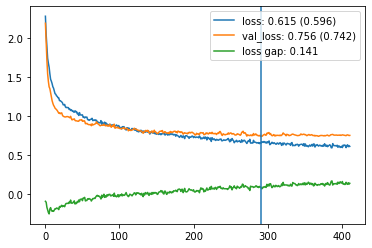


Epoch 00412: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
Epoch 00412: early stopping


In [227]:
model.fit(train_data, 
          train_labels_enc,
          batch_size=64,
          validation_data=(val_data, val_labels_enc), 
          class_weight=class_weights,
          verbose=0,
          epochs=epoch_size, 
          callbacks=callbacks)

In [228]:
from sklearn.metrics import log_loss

val_preds = model.predict(val_data)
train_preds = model.predict(train_data)
print('val loss: ',log_loss(val_labels_enc, val_preds))
print('train loss: ',log_loss(train_labels_enc, train_preds))

val loss:  0.7555312966228694
train loss:  0.521352439996967


### Confusion matrix

In [229]:
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix
from keras.models import load_model

from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

# Load best model
best_model = load_model(str(models_dir / f_checkpoint_val))

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_probs = best_model.predict(val_data)

val_preds = np.argmax(val_probs, axis=1)

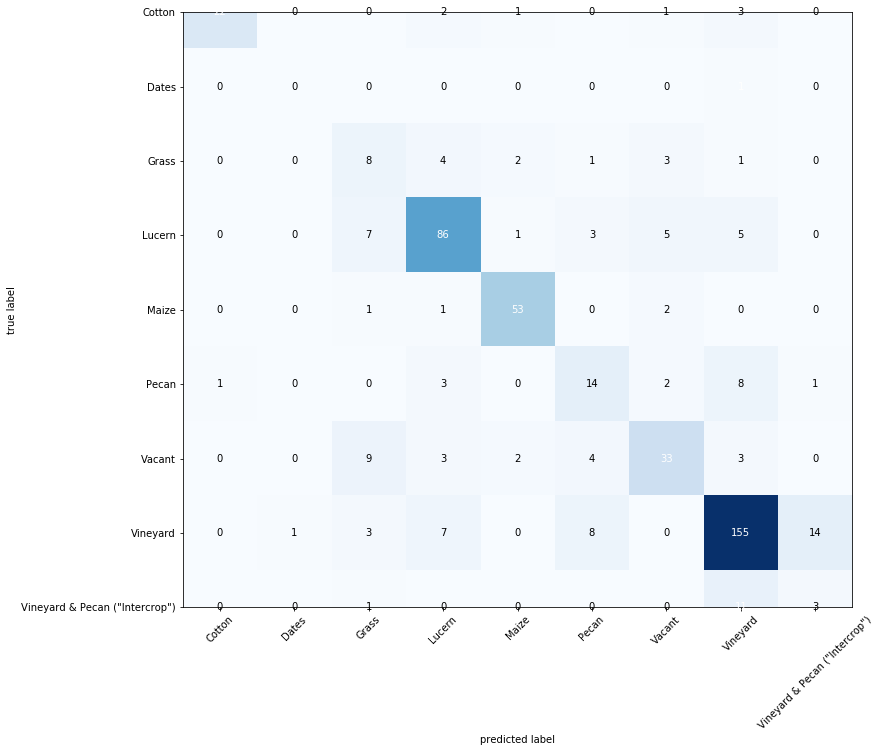

In [230]:
cm = confusion_matrix(val_labels_enc, val_preds)
plot_confusion_matrix(cm, class_names=class_labels, figsize=(12,12));

## Make Submission

### First retrain on all data


In [ ]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

In [ ]:
model = get_model(all_data.shape[-1])
optimizer = keras.optimizers.RMSprop(0.00015)
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(all_data, 
          all_labels,
          batch_size=64, 
          verbose=2,
          epochs=350,  
          callbacks=callbacks)

In [ ]:
test_ids[:10]

In [ ]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict(test_data)
test_ids = sorted(list(map(int,test_features_df.farm_id.unique())))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

### Save submission file

In [ ]:
from config import subs_dir

sub_df.to_csv(subs_dir / 'gru_vi_data_6.1_SMOTE.csv')

### Save model architecture

In [ ]:
with open(subs_dir / 'architectures')